In [1]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tensorflow.keras.regularizers import l2
from tqdm import tqdm

In [3]:
# Define the dataset path
dataset_path = r"C:\Users\gchaw\OneDrive\Desktop\pythonwork\Null Class\Age finder project 1\UTKFace"
# Load the dataset
data, labels = [], []  # Initialize lists for storing images and labels
for img_name in tqdm(os.listdir(dataset_path)):
    if img_name.endswith(".jpg"):
        # Extract age from filename
        age = int(img_name.split("_")[0])
        # Read and resize the image
        img_path = os.path.join(dataset_path, img_name)
        image = cv2.imread(img_path)
        image = cv2.resize(image, (128, 128))
        data.append(image)
        labels.append(age)

# Limit dataset size (optional)
subset_size = 12500  # Use only 12,500 samples
data = data[:subset_size]
labels = labels[:subset_size]

# Convert data to NumPy arrays
data = np.array(data, dtype="float32") / 255.0  # Normalize pixel values
labels = np.array(labels)


100%|██████████| 23708/23708 [05:19<00:00, 74.30it/s] 


In [4]:
# Define the age bins (example bins, modify as needed)
age_bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90]

# Convert age labels to age bin indices
labels = np.digitize(labels, bins=age_bins) - 1  # Convert ages to bin indices

# Convert labels to categorical format
labels = to_categorical(labels, num_classes=len(age_bins))

In [5]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

In [6]:
# Load the MobileNetV2 model
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(128, 128, 3))

# Unfreeze some layers for fine-tuning
base_model.trainable = True
for layer in base_model.layers[:-30]:  # Freeze all layers except the last 30
    layer.trainable = False

# Add custom layers with L2 regularization and Dropout
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation="relu", kernel_regularizer=l2(0.01))(x)  # Add L2 regularization
x = Dropout(0.5)(x)  # Apply Dropout
output = Dense(len(age_bins), activation="softmax")(x)  # Output layer for classification

# Build the model
model = Model(inputs=base_model.input, outputs=output)

# Recompile the model with a lower learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=1e-5), loss="categorical_crossentropy", metrics=["accuracy"])

# Display the model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 4,880,842 (18.62 MB)

 Trainable params: 4,149,258 (15.83 MB)

 Non-trainable params: 731,584 (2.79 MB)

In [7]:
# Use a lower learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=1e-5), loss="categorical_crossentropy", metrics=["accuracy"])

In [8]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=14,
    batch_size=32,
    verbose=1
)

Epoch 1/14
313/313 ━━━━━━━━━━━━━━━━━━━━ 187s 482ms/step - accuracy: 0.4367 - loss: 4.4638 - val_accuracy: 0.6448 - val_loss: 3.5010
Epoch 2/14
313/313 ━━━━━━━━━━━━━━━━━━━━ 142s 454ms/step - accuracy: 0.6389 - loss: 3.4843 - val_accuracy: 0.6792 - val_loss: 3.3427
Epoch 3/14
313/313 ━━━━━━━━━━━━━━━━━━━━ 124s 398ms/step - accuracy: 0.6706 - loss: 3.3175 - val_accuracy: 0.7192 - val_loss: 3.1846
Epoch 4/14
313/313 ━━━━━━━━━━━━━━━━━━━━ 133s 425ms/step - accuracy: 0.6967 - loss: 3.1811 - val_accuracy: 0.7244 - val_loss: 3.1153
Epoch 5/14
313/313 ━━━━━━━━━━━━━━━━━━━━ 129s 412ms/step - accuracy: 0.7371 - loss: 3.0422 - val_accuracy: 0.7348 - val_loss: 3.0343
Epoch 6/14
313/313 ━━━━━━━━━━━━━━━━━━━━ 144s 460ms/step - accuracy: 0.7528 - loss: 2.9041 - val_accuracy: 0.7284 - val_loss: 2.9593
Epoch 7/14
313/313 ━━━━━━━━━━━━━━━━━━━━ 131s 419ms/step - accuracy: 0.7747 - loss: 2.7876 - val_accuracy: 0.7320 - val_loss: 2.9105
Epoch 8/14
313/313 ━━━━━━━━━━━━━━━━━━━━ 128s 409ms/step - accuracy: 0.7876 -

In [9]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

79/79 ━━━━━━━━━━━━━━━━━━━━ 23s 285ms/step - accuracy: 0.7443 - loss: 2.5832
Test Loss: 2.5871880054473877
Test Accuracy: 0.7376000285148621


In [13]:
# ------------------------------
# ADDED: Evaluation Metrics Calculation (Confusion Matrix, Precision, Recall)
# ------------------------------
from sklearn.metrics import confusion_matrix, precision_score, recall_score, classification_report

# Generate predictions for the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Calculate and display the confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test_classes, y_pred_classes))

# Print a full classification report (includes precision, recall, and F1-score)
print("\nClassification Report:")
print(classification_report(y_test_classes, y_pred_classes))

# Display overall weighted precision and recall
print("Precision:", precision_score(y_test_classes, y_pred_classes, average='weighted'))
print("Recall:", recall_score(y_test_classes, y_pred_classes, average='weighted'))

79/79 ━━━━━━━━━━━━━━━━━━━━ 17s 216ms/step
Confusion Matrix:
[[ 316    5   13    0    0]
 [  10  138  154   11    0]
 [   2   34 1349   87    0]
 [   2    7  327   38    0]
 [   0    0    4    0    3]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.95      0.95       334
           1       0.75      0.44      0.56       313
           2       0.73      0.92      0.81      1472
           3       0.28      0.10      0.15       374
           9       1.00      0.43      0.60         7

    accuracy                           0.74      2500
   macro avg       0.74      0.57      0.61      2500
weighted avg       0.70      0.74      0.70      2500

Precision: 0.6964760843956621
Recall: 0.7376


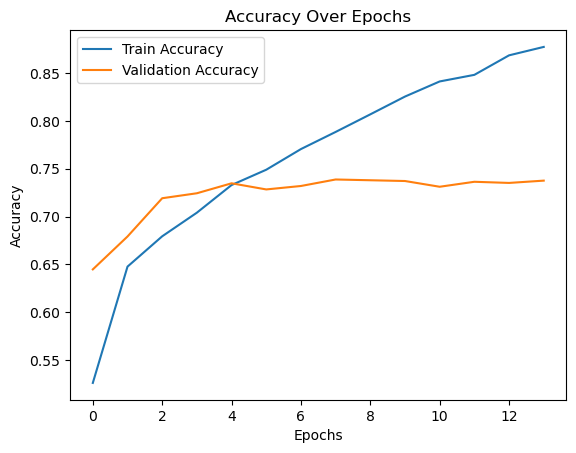

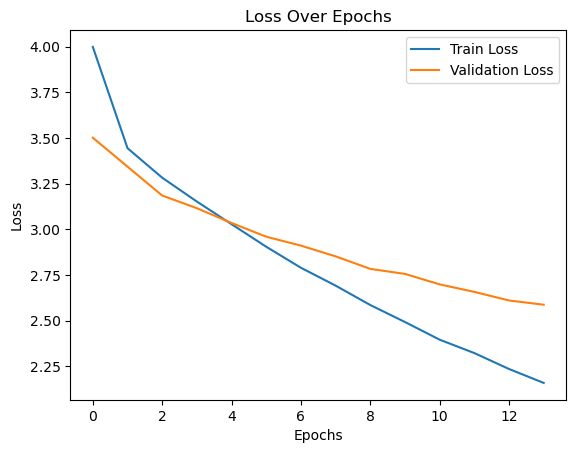

In [10]:
# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title("Accuracy Over Epochs")
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title("Loss Over Epochs")
plt.show()

79/79 ━━━━━━━━━━━━━━━━━━━━ 25s 284ms/step


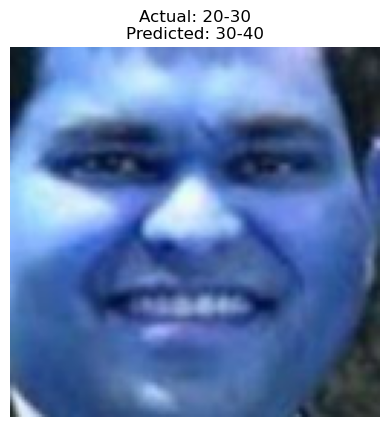

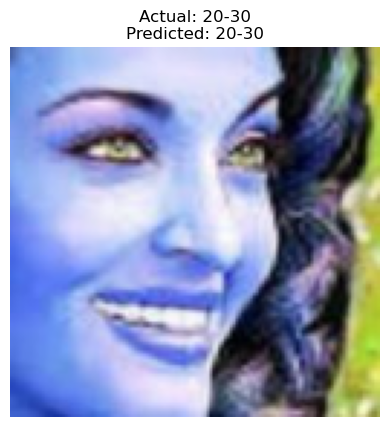

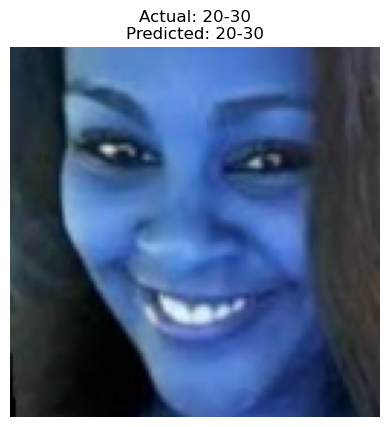

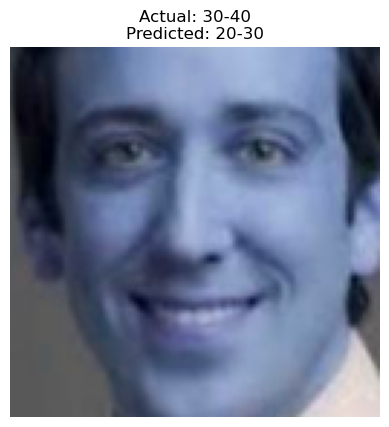

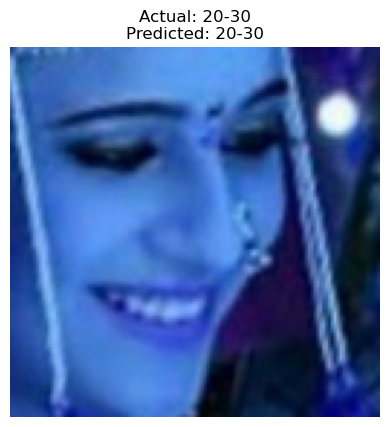

In [11]:
import random
import matplotlib.pyplot as plt

# Generate predictions for the test set
y_pred = model.predict(X_test)

# Convert predictions and actual labels from one-hot to class indices
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Randomly select indices to visualize
random_indices = random.sample(range(len(X_test)), 5)  # Select 5 random samples

# Plot the selected samples with predictions
for idx in random_indices:
    plt.imshow(X_test[idx])
    plt.title(f"Actual: {age_bins[y_test_classes[idx]]}-{age_bins[y_test_classes[idx] + 1]}\n"
              f"Predicted: {age_bins[y_pred_classes[idx]]}-{age_bins[y_pred_classes[idx] + 1]}")
    plt.axis("off")
    plt.show()

In [12]:
model.save("my_project_name.keras")
print("Model saved as my_project_name.keras")

Model saved as my_project_name.keras
